## Tiltmeter and Sagnac Frequency

### Import Libraries

In [49]:
%autosave 120

import os
import yaml
import matplotlib.pyplot as plt

from pandas import read_csv, DataFrame, date_range
from obspy import UTCDateTime, read, Stream
from numpy import nanmean 

from andbro__readYaml import __readYaml
from andbro__savefig import __savefig

Autosaving every 120 seconds


In [2]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/"
    data_path = "/home/andbro/kilauea-data/"
    archive_path = "/home/andbro/freenas/"
elif os.uname().nodename == "kilauea":
    root_path = "/home/brotzer/"
    data_path = "/import/kilauea-data/"
    archive_path = "/import/freenas-ffb-01-data/"

### Define Functions

In [3]:
def __makeplot(pt, bt, config):
    
    fig, axes = plt.subplots(3,2, figsize=(15,5), sharex=True)
    
    font = 14
    
    pt.sort()
    bt.sort()

    for i in range(3):
        
        axes[i,0].plot(pt[i].times(reftime=UTCDateTime("2019-01-01T00"))/3600, pt[i].data, label=pt[i].stats.channel)
        axes[i,1].plot(bt[i].times(reftime=UTCDateTime("2019-01-01T00"))/3600, bt[i].data, label=pt[i].stats.channel)
        
        axes[i,0].grid()
        axes[i,1].grid()
        
        axes[i,0].legend(loc=1)
        axes[i,1].legend(loc=1)
        
        axes[i,0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axes[i,1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    axes[2,0].ticklabel_format(axis="y", style="plain")
    axes[2,1].ticklabel_format(axis="y", style="plain")    
        
    axes[2,0].set_xlabel("Time (hours)", fontsize=font)
    axes[2,1].set_xlabel("Time (hours)", fontsize=font)
    
    axes[0,0].set_ylabel("E (rad)", fontsize=font)
    axes[1,0].set_ylabel("N (rad)", fontsize=font)
    axes[2,0].set_ylabel("Temp (°C)", fontsize=font)
    
    axes[0,0].set_title(f"{pt[0].stats.station}")
    axes[0,1].set_title(f"{bt[0].stats.station}")
    
    return fig 

In [4]:
def __conversion(st, conf):

    st0 = st.copy()
    
    def convertTemp(trace):
        Tvolt = trace.data * conf.get('gainTemp')
        coeff = conf.get('calcTempCoefficients')
        return coeff[0] + coeff[1]*Tvolt + coeff[2]*Tvolt**2 + coeff[3]*Tvolt**3
    
    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity

    for tr in st0:
        if tr.stats.channel[-1] == 'T':
            tr.data = convertTemp(tr)
        elif tr.stats.channel[-1] == 'N':
            tr.data = convertTilt(tr, conf['convTN'], conf['gainTilt'])
        elif tr.stats.channel[-1] == 'E':
            tr.data = convertTilt(tr, conf['convTE'], conf['gainTilt'])
        else:
            print("no match")
            
    print(f"  -> converted data of {st[0].stats.station}")
    return st0

In [5]:
def __smooth(y, box_pts):
    from numpy import ones, convolve, hanning

#     win = ones(box_pts)/box_pts
    win = hanning(box_pts)
    y_smooth = convolve(y, win/sum(win), mode='same')

    return y_smooth

### Configurations

In [6]:
## configurations
config={}

config['save'] = False

## get 'raw' data from romy archive
# config['datapath'] = f"{archive_path}/romy_archive"

## get downsampled data 
config['datapath'] = f"{data_path}TiltmeterDataBackup/Tilt_downsampled"

## time selection
config['tbeg'] = UTCDateTime("2022-04-24 00:00")
# config['tend'] = UTCDateTime("2022-05-31 00:00")
config['tend'] = UTCDateTime("2022-06-12 00:00")

## specify output directory for figures
config['output_figures'] = f"{root_path}Documents/ROMY/tiltmeter/figures/"

## indicate path to wromy data
config['pathToWromy'] = f"{data_path}wromy/"

## gain for Temperature channel of PT was not set correctly prior to 2021-03-03
correct_settings_temp_PT = ("2021-03-05", config['tend'])

## tiltmeter configurations
confTilt = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter.conf")

## correction of offset (e.g. reset mass)
offset_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter_steps.yml")

## correction for temperature trends
## based on MAT
temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","temperature_correction.yml")
## based on WSX
# temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","temperature_correction_new.yml")


In [7]:
def __load_local(config, seed_id):
    
    from tqdm.notebook import tqdm
    from obspy.clients.filesystem.sds import Client
    
    net, sta, loc, cha = seed_id.split(".")
    
    tbeg, tend = config['tbeg'], config['tend']

    st0 = Client(config['datapath'],fileborder_samples=1000).get_waveforms(net, sta, loc, cha, tbeg, tend)
    
    st0.merge()
    
    return st0

### Load ROMY Saganac Frequency

In [8]:
def __load_data(config):
    
    from datetime import date
    from pandas import read_pickle, concat

    t1 = date.fromisoformat(str(config['tbeg'].date))
    t2 = date.fromisoformat(str(config['tend'].date))

    df = DataFrame()
    for dat in date_range(t1,t2):
        file = str(dat)[:10].replace("-","")+".pkl"
        try:
            df0 = read_pickle(config['datadir']+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")
            
    return df

In [9]:
config['datadir'] = "/home/andbro/kilauea-data/sagnac_frequency/hilbert_60_tilt/"

df1 = __load_data(config)
     
from numpy import where, nan, array
from obspy import Trace
df1['freqs'] = where(df1['psd_max'] > 1e5, df1['freqs'], nan)

beat = Trace()
beat.data = array(df1['freqs'])
beat.stats.starttime = config['tbeg']
beat.stats.sampling_rate = 1/60


### Load Tiltmeter Data

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-11T23:50:00.039999Z | 600.0 s, 7056 samples


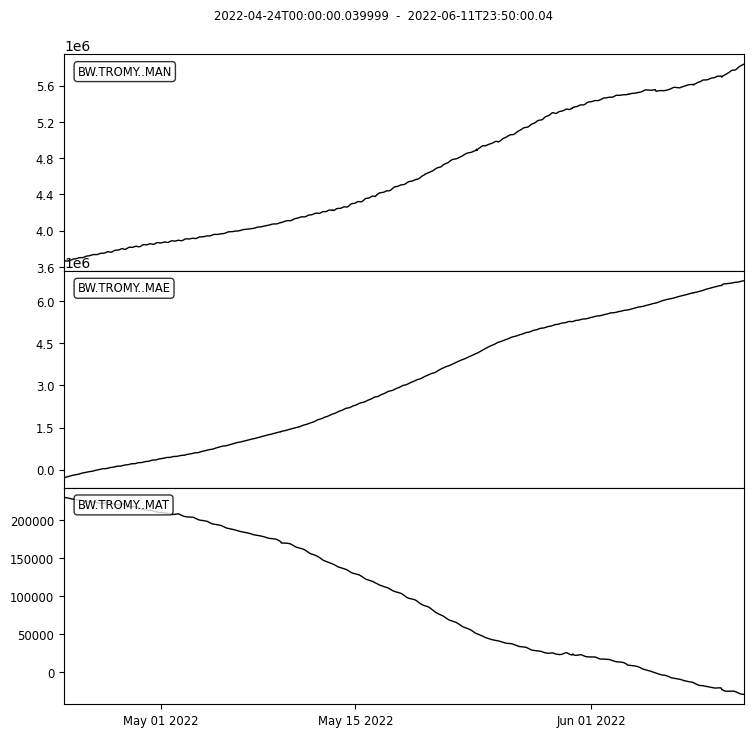

In [10]:
TROMY0 = __load_local(config, "BW.TROMY..MA*")
TROMY0.sort()
print(TROMY0)
TROMY0.plot(equal_scale=False);

3 Trace(s) in Stream:
BW.ROMYT..MAE | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples
BW.ROMYT..MAN | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples
BW.ROMYT..MAT | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples


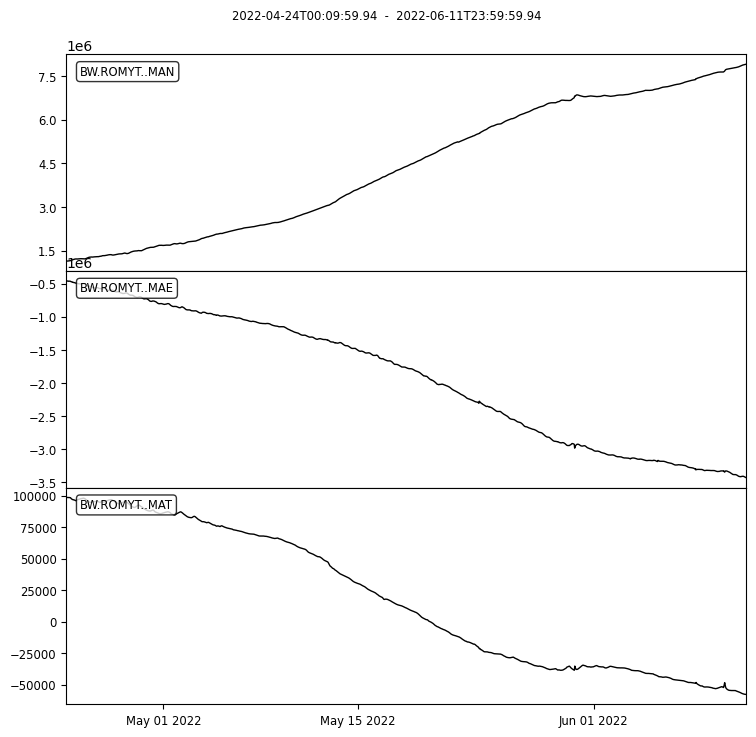

In [11]:
ROMYT0 = __load_local(config, "BW.ROMYT..MA*")
ROMYT0.sort()
print(ROMYT0)
ROMYT0.plot(equal_scale=False);

3 Trace(s) in Stream:
BW.DROMY..LAE | 2022-04-24T00:00:00.000000Z - 2022-06-12T00:00:00.000000Z | 600.0 s, 7057 samples (masked)
BW.DROMY..LAN | 2022-04-24T00:00:00.000000Z - 2022-06-12T00:00:00.000000Z | 600.0 s, 7057 samples (masked)
BW.DROMY..LAT | 2022-04-24T00:00:00.000000Z - 2022-06-12T00:00:00.000000Z | 600.0 s, 7057 samples (masked)


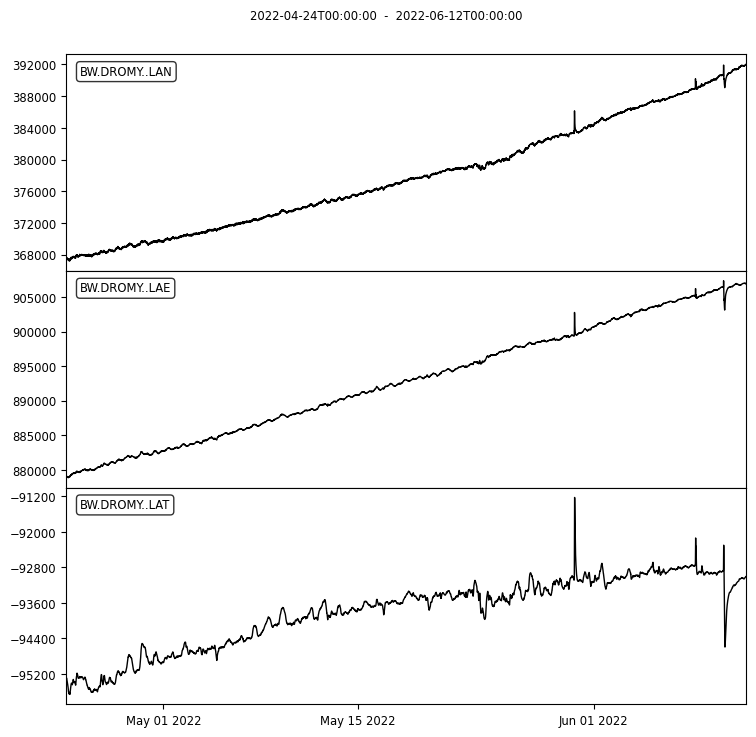

In [12]:
BROMY0 = __load_local(config, "BW.DROMY..LA*")
BROMY0.sort()
print(BROMY0)
BROMY0.plot(equal_scale=False);

### Data Conversion to rad

In [744]:
TROMY = __conversion(TROMY0, confTilt['TROMY'])
ROMYT = __conversion(ROMYT0, confTilt['ROMYT'])
BROMY = __conversion(BROMY0, confTilt['BROMY'])

  -> converted data of TROMY
  -> converted data of ROMYT
  -> converted data of DROMY


### Reset Tilt at Start

In [745]:
## Reset start to Zero
for st in [TROMY, ROMYT, BROMY]:
    for tr in st:
        if not tr.stats.channel[-1] == "T" or tr.stats.channel[0] == "W":
            tr.data -= tr.data[1]

In [746]:
def __plot_all_tilt(st1, st2, st3):

    from datetime import datetime
    
    NN=3
    
    fig, ax = plt.subplots(NN,1, figsize=(15,8), sharex=True)

    font = 14
    
    tilt_scaling, tilt_unit = 1e-6, r"$\mu$rad"
    time_scaling, time_unit = 86400, "days"
    
    ax[0].plot(st1.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*N")[0].data/tilt_scaling, label="TROMY")
    ax[0].plot(st2.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*N")[0].data/tilt_scaling, label="ROMYT")
    ax[0].plot(st3.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*N")[0].data/tilt_scaling, label="BROMY")

    ax[1].plot(st1.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st2.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st3.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*E")[0].data/tilt_scaling)

    ax[2].plot(st1.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*T")[0].data)
    ax[2].plot(st2.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*T")[0].data)
    ax[2].plot(st3.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*T")[0].data)

    ax[0].set_ylabel(f"N ({tilt_unit})", fontsize=font)
    ax[1].set_ylabel(f"E ({tilt_unit})", fontsize=font)
    ax[2].set_ylabel(f"T (°C)", fontsize=font)
#     ax[2].set_xlabel(f"Time ({time_unit})", fontsize=font)
    
    for o in range(3):
        ax[o].grid()
    
    ax[0].legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.7, 1.1), ncol=3, framealpha=1)
    
    tcks= ax[NN-1].get_xticks()
    tcklbls = [datetime.fromtimestamp(t*time_scaling+datetime(2019,1,1).timestamp()).strftime("%Y-%m-%d") for t in tcks]
    ax[NN-1].set_xticklabels(tcklbls)
    
    plt.show();
    return fig

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


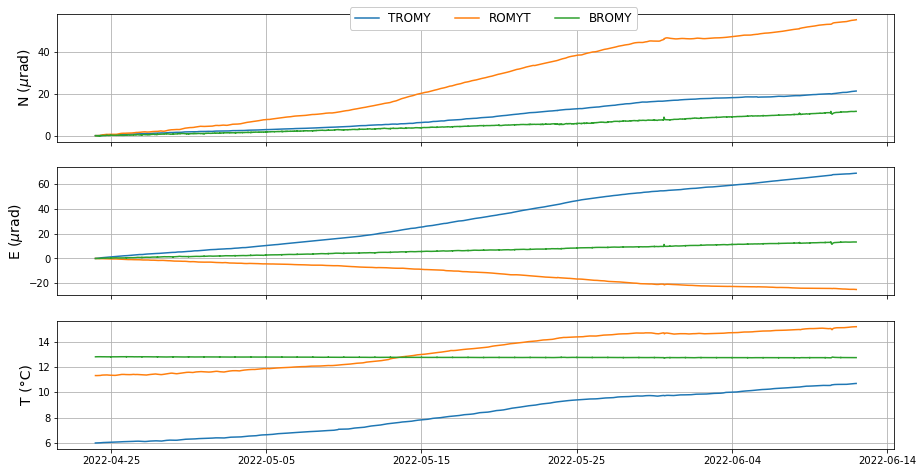

In [747]:
fig = __plot_all_tilt(TROMY, ROMYT, BROMY)   

### Correct for linear temperature effect on components

In [739]:
def __correct_temperature_trend(st, correction):
    
    st0 = st.copy()
    temperature = st0.select(channel="*T")[0].data
    
#     st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
#     st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature + correction['N_intercept'])
    st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature)
    st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature)
    
    return st0

In [740]:
## load correction model
# temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","temperature_correction.yml")

## apply correction model
TROMY = __correct_temperature_trend(TROMY, temperature_correction['TROMY'])
ROMYT = __correct_temperature_trend(ROMYT, temperature_correction['ROMYT'])
BROMY = __correct_temperature_trend(BROMY, temperature_correction['BROMY'])

In [741]:
## Reset start to Zero
for st in [TROMY, ROMYT, BROMY]:
    for tr in st:
        if not tr.stats.channel[-1] == "T" or tr.stats.channel[0] == "W":
            tr.data -= tr.data[1]

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


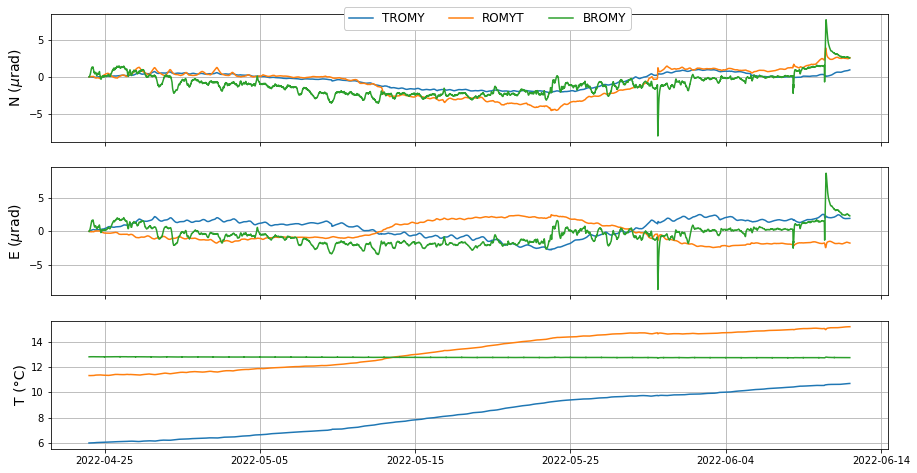

In [742]:
fig = __plot_all_tilt(TROMY, ROMYT, BROMY)   

### Manipulate Components

In [748]:
## change polarity of Channel
# TRII.select(channel="*E")[0].data *= -1

## exchange N and E
# TRII.select(channel="*E")[0].stats.channel = "MAP"
# TRII.select(channel="*N")[0].stats.channel = "MAE"
# TRII.select(channel="*P")[0].stats.channel = "MAN"

# fig = __makeplot(TROMY, TRII, config);

### Join 

In [749]:
st_all = Stream()

st_all += ROMYT.copy().select(channel="*N").split()
st_all += ROMYT.copy().select(channel="*E").split()

st_all += TROMY.copy().select(channel="*N").split()
st_all += TROMY.copy().select(channel="*E").split()

st_all += BROMY.copy().select(channel="*N").split()
st_all += BROMY.copy().select(channel="*E").split()

st_all.merge(method=1, fill_value='interpolate')


st_all_pp = st_all.copy()

# st_all_pp.detrend('simple')
# st_all_pp.taper(0.05);

In [759]:
st_f1 = st_all_pp.copy()


st_f2 = st_all_pp.copy()

# fmin, fmax = 1/(2*86400), 1/(0.1*86400)
# filter_str = f"bp: {fmin:.2e} - {fmax:.2e} Hz"
# st_f2.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

6 Trace(s) in Stream:
BW.DROMY..LAE | 2022-04-24T00:10:00.000000Z - 2022-06-11T23:50:00.000000Z | 600.0 s, 7055 samples
BW.DROMY..LAN | 2022-04-24T00:10:00.000000Z - 2022-06-11T23:50:00.000000Z | 600.0 s, 7055 samples
BW.ROMYT..MAE | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples
BW.ROMYT..MAN | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples

### Load Estimated Earth Tides

In [760]:
def __load_theoretical_tilt():

    from pandas import read_csv
    from obspy import Trace, Stream
    from numpy import array

    ## load dataframe
    df = read_csv(config['datapath']+"/../../tilts_theory.csv")
    df.head()

    ## prepare traces
    tr_tilt = Trace()
    tr_tilt.stats.starttime = UTCDateTime(df['times'][0])
    tr_tilt.stats.delta = 600

    tr_tilt_N = tr_tilt.copy()
    tr_tilt_N.stats.channel = "NNN"
    tr_tilt_N.data = array(df['tiltN'])

    tr_tilt_E = tr_tilt.copy()
    tr_tilt_E.stats.channel = "EEE"
    tr_tilt_E.data = array(df['tiltE'])

    # form stream
    tilt_theo = Stream()
    tilt_theo += tr_tilt_N
    tilt_theo += tr_tilt_E
    
    return tilt_theo

In [761]:
tilt_theo = __load_theoretical_tilt()

# tilt_theo.detrend("simple")
# tilt_theo.taper(0.05)
# tilt_theo.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

## double amplitudes for better match.. not yet understood!
# for tr in tilt_theo:
#     tr.data *= 2

## Plot Tide Load

In [762]:
def __makeplot_earth_tides():
    NN = 6

    font = 14
    linew = 1.3
    
    fig, ax = plt.subplots(NN, 1, figsize=(15,12), sharex=True)

    scaling = 1e6 ## micro strain
    scaling_time = 86400

    ## not filtered
    tromy_n_trace = st_all.select(station="TROMY", channel="MAN")[0]
    tromy_e_trace = st_all.select(station="TROMY", channel="MAE")[0]
    romyt_n_trace = st_all.select(station="ROMYT", channel="MAN")[0]
    romyt_e_trace = st_all.select(station="ROMYT", channel="MAE")[0]
    bromy_n_trace = st_all.select(station="DROMY", channel="LAN")[0]
    bromy_e_trace = st_all.select(station="DROMY", channel="LAE")[0]
    
    ## bandpass 1
    tromy_n_trace_pp = st_f1.select(station="TROMY", channel="MAN")[0]
    romyt_n_trace_pp = st_f1.select(station="ROMYT", channel="MAN")[0]
    tromy_e_trace_pp = st_f1.select(station="TROMY", channel="MAE")[0]
    romyt_e_trace_pp = st_f1.select(station="ROMYT", channel="MAE")[0]
    bromy_n_trace_pp = st_f1.select(station="DROMY", channel="LAN")[0]
    bromy_e_trace_pp = st_f1.select(station="DROMY", channel="LAE")[0]
    
    ## bandpass 2
    tromy_n_trace_bp = st_f2.select(station="TROMY", channel="MAN")[0]
    romyt_n_trace_bp = st_f2.select(station="ROMYT", channel="MAN")[0]
    tromy_e_trace_bp = st_f2.select(station="TROMY", channel="MAE")[0]
    romyt_e_trace_bp = st_f2.select(station="ROMYT", channel="MAE")[0]
    bromy_n_trace_bp = st_f2.select(station="DROMY", channel="LAN")[0]
    bromy_e_trace_bp = st_f2.select(station="DROMY", channel="LAE")[0]
    

    ax[0].plot(tromy_n_trace.times()/scaling_time, tromy_n_trace.data*scaling, label="TROMY", lw=linew, zorder=3)
    ax[0].plot(romyt_n_trace.times()/scaling_time, romyt_n_trace.data*scaling, label="ROMYT", lw=linew, zorder=2)
    ax[0].plot(bromy_n_trace.times()/scaling_time, bromy_n_trace.data*scaling, label="BROMY", lw=linew, zorder=1)

    ax[1].plot(tromy_n_trace_pp.times()/scaling_time, tromy_n_trace_lp.data*scaling, label="{filter_str}", lw=linew, zorder=3)
    ax[1].plot(romyt_n_trace_pp.times()/scaling_time, romyt_n_trace_lp.data*scaling, label="{filter_str}", lw=linew, zorder=2)
    ax[1].plot(bromy_n_trace_pp.times()/scaling_time, bromy_n_trace_lp.data*scaling, label="{filter_str}", lw=linew, zorder=1)
    
    ax[2].plot(tromy_n_trace_bp.times()/scaling_time, tromy_n_trace_bp.data*scaling, label=f"{filter_str} Hz", lw=linew, zorder=3)
    ax[2].plot(romyt_n_trace_bp.times()/scaling_time, romyt_n_trace_bp.data*scaling, label=f"{filter_str} Hz", lw=linew, zorder=2)   
    ax[2].plot(bromy_n_trace_bp.times()/scaling_time, bromy_n_trace_bp.data*scaling, label=f"{filter_str} Hz", lw=linew, zorder=1)   

    ax[3].plot(tromy_e_trace.times()/scaling_time, tromy_e_trace.data*scaling, label=f"{filter_str} Hz", lw=linew, zorder=3)
    ax[3].plot(romyt_e_trace.times()/scaling_time, romyt_e_trace.data*scaling, label=f"{filter_str} Hz", lw=linew, zorder=2)
    ax[3].plot(bromy_e_trace.times()/scaling_time, bromy_e_trace.data*scaling, label=f"{filter_str} Hz", lw=linew, zorder=1)
    
    ax[4].plot(tromy_e_trace_pp.times()/scaling_time, tromy_e_trace_lp.data*scaling, label=f"{filter_str}", lw=linew, zorder=3)
    ax[4].plot(romyt_e_trace_pp.times()/scaling_time, romyt_e_trace_lp.data*scaling, label=f"{filter_str}", lw=linew, zorder=2)
    ax[4].plot(bromy_e_trace_pp.times()/scaling_time, bromy_e_trace_lp.data*scaling, label=f"{filter_str}", lw=linew, zorder=1)
    
    ax[5].plot(tromy_e_trace_bp.times()/scaling_time, tromy_e_trace_bp.data*scaling, label="test", lw=linew, zorder=3)
    ax[5].plot(romyt_e_trace_bp.times()/scaling_time, romyt_e_trace_bp.data*scaling, label="test", lw=linew, zorder=2)
    ax[5].plot(bromy_e_trace_bp.times()/scaling_time, bromy_e_trace_bp.data*scaling, label="test", lw=linew, zorder=1)
    
    ax[2].plot(tilt_theo.select(channel="*N")[0].times()/scaling_time, tilt_theo.select(channel="*N")[0].data*scaling, 'k', zorder=0)
    ax[5].plot(tilt_theo.select(channel="*E")[0].times()/scaling_time, tilt_theo.select(channel="*E")[0].data*scaling, 'k', zorder=0)

    ax[1].set_title("detrend & taper ", loc="right", fontsize=font-1, pad=2)
    ax[2].set_title("highpass 2 days ", loc="right", fontsize=font-1, pad=2)
    ax[4].set_title("detrend & taper ", loc="right", fontsize=font-1, pad=2)
    ax[5].set_title("highpass 2 days ", loc="right", fontsize=font-1, pad=2)

        
    ax[0].set_ylabel("North ($\mu$rad)", fontsize=font)
    ax[1].set_ylabel("North ($\mu$rad)", fontsize=font)
    ax[2].set_ylabel("North ($\mu$rad)", fontsize=font)
    ax[3].set_ylabel("East ($\mu$rad)", fontsize=font)
    ax[4].set_ylabel("East ($\mu$rad)", fontsize=font)
    ax[5].set_ylabel("East ($\mu$rad)", fontsize=font)

    ax[NN-1].set_xlabel(f"Time from {tromy_n_trace.stats.starttime.date} (days)", fontsize=font)

    ax[0].legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.65, 1.2), ncol=3, framealpha=1)


    
#     lim = 5
#     ax[0].set_ylim(-lim,lim)
#     ax[3].set_ylim(-lim,lim)   
    
    lim = .4
    ax[1].set_ylim(-lim,lim)
    ax[4].set_ylim(-lim,lim)

    lim = .4
    ax[2].set_ylim(-lim,lim)
    ax[5].set_ylim(-lim,lim)
    
    
    plt.show();
    return fig

# __makeplot_earth_tides();

In [763]:
# __savefig(fig, outpath=config['output_figures'], outname="Tilt_ALL_EarthTides_NO_TempCorrect", mode="png", dpi=None)

In [764]:
def __makeplot_earth_tides2():
    NN = 4

    font = 14
    linew = 1.3
    
    fig, ax = plt.subplots(NN, 1, figsize=(15,12), sharex=True)

    scaling = 1e6 ## micro strain
    scaling_time = 86400

    ## not filtered
    tromy_n_trace = st_all.select(station="TROMY", channel="MAN")[0]
    tromy_e_trace = st_all.select(station="TROMY", channel="MAE")[0]
    romyt_n_trace = st_all.select(station="ROMYT", channel="MAN")[0]
    romyt_e_trace = st_all.select(station="ROMYT", channel="MAE")[0]
    bromy_n_trace = st_all.select(station="DROMY", channel="LAN")[0]
    bromy_e_trace = st_all.select(station="DROMY", channel="LAE")[0]
    
    ## bandpass 1
    tromy_n_trace_bp = st_f1.select(station="TROMY", channel="MAN")[0]
    romyt_n_trace_bp = st_f1.select(station="ROMYT", channel="MAN")[0]
    tromy_e_trace_bp = st_f1.select(station="TROMY", channel="MAE")[0]
    romyt_e_trace_bp = st_f1.select(station="ROMYT", channel="MAE")[0]
    bromy_n_trace_bp = st_f1.select(station="DROMY", channel="LAN")[0]
    bromy_e_trace_bp = st_f1.select(station="DROMY", channel="LAE")[0]
    
    ## bandpass 2
    tromy_n_trace_lp = st_f2.select(station="TROMY", channel="MAN")[0]
    romyt_n_trace_lp = st_f2.select(station="ROMYT", channel="MAN")[0]
    tromy_e_trace_lp = st_f2.select(station="TROMY", channel="MAE")[0]
    romyt_e_trace_lp = st_f2.select(station="ROMYT", channel="MAE")[0]
    bromy_n_trace_lp = st_f2.select(station="DROMY", channel="LAN")[0]
    bromy_e_trace_lp = st_f2.select(station="DROMY", channel="LAE")[0]
    

    ax[0].plot(tromy_n_trace.times()/scaling_time, tromy_n_trace.data*scaling, label="TROMY", lw=linew, zorder=3)
    ax[0].plot(romyt_n_trace.times()/scaling_time, romyt_n_trace.data*scaling, label="ROMYT", lw=linew, zorder=2)
    ax[0].plot(bromy_n_trace.times()/scaling_time, bromy_n_trace.data*scaling, label="BROMY", lw=linew, zorder=1)

    ax[1].plot(tromy_n_trace_bp.times()/scaling_time, tromy_n_trace_bp.data*scaling, label=f"{filter_str} Hz", lw=linew, zorder=3)
    ax[1].plot(romyt_n_trace_bp.times()/scaling_time, romyt_n_trace_bp.data*scaling, label=f"{filter_str} Hz", lw=linew, zorder=2)   
    ax[1].plot(bromy_n_trace_bp.times()/scaling_time, bromy_n_trace_bp.data*scaling, label=f"{filter_str} Hz", lw=linew, zorder=1)   

    ax[2].plot(tromy_e_trace.times()/scaling_time, tromy_e_trace.data*scaling, label=f"{filter_str} Hz", lw=linew, zorder=3)
    ax[2].plot(romyt_e_trace.times()/scaling_time, romyt_e_trace.data*scaling, label=f"{filter_str} Hz", lw=linew, zorder=2)
    ax[2].plot(bromy_e_trace.times()/scaling_time, bromy_e_trace.data*scaling, label=f"{filter_str} Hz", lw=linew, zorder=1)
    
    ax[3].plot(tromy_e_trace_bp.times()/scaling_time, tromy_e_trace_bp.data*scaling, label="test", lw=linew, zorder=3)
    ax[3].plot(romyt_e_trace_bp.times()/scaling_time, romyt_e_trace_bp.data*scaling, label="test", lw=linew, zorder=2)
    ax[3].plot(bromy_e_trace_bp.times()/scaling_time, bromy_e_trace_bp.data*scaling, label="test", lw=linew, zorder=1)
    

    ax[1].set_title("highpass 2 days ", loc="right", fontsize=font-1, pad=2)
    ax[3].set_title("highpass 2 days ", loc="right", fontsize=font-1, pad=2)
        
    ax[0].set_ylabel("North ($\mu$rad)", fontsize=font)
    ax[1].set_ylabel("North ($\mu$rad)", fontsize=font)
    ax[2].set_ylabel("East ($\mu$rad)", fontsize=font)
    ax[3].set_ylabel("East ($\mu$rad)", fontsize=font)

    ax[NN-1].set_xlabel(f"Time from {st[0].stats.starttime.date} (days)", fontsize=font)

    ax[0].legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.65, 1.2), ncol=3, framealpha=1)
   

    lim = 1
    ax[1].set_ylim(-lim,lim)
    ax[3].set_ylim(-lim,lim)
    
    
    plt.show();
    return fig

# __makeplot_earth_tides2();

In [765]:
def __makeplot():

    fig, ax = plt.subplots(2,1, figsize=(15,8),sharex=True)

    plt.subplots_adjust(hspace=0.1)
    
    font = 14
    linew = 1.3
    scaling, unit = 1e6, r"$\mu$rad" ## micro strain
    scaling_time = 86400


    tromy_n_trace_lp = st_f2.select(station="TROMY", channel="MAN")[0]
    romyt_n_trace_lp = st_f2.select(station="ROMYT", channel="MAN")[0]
    tromy_e_trace_lp = st_f2.select(station="TROMY", channel="MAE")[0]
    romyt_e_trace_lp = st_f2.select(station="ROMYT", channel="MAE")[0]
    bromy_n_trace_lp = st_f2.select(station="DROMY", channel="LAN")[0]
    bromy_e_trace_lp = st_f2.select(station="DROMY", channel="LAE")[0]

    ax[0].plot(tromy_n_trace_lp.times()/scaling_time, tromy_n_trace_lp.data*scaling, label=f"TROMY", lw=linew, zorder=3)
    ax[0].plot(romyt_n_trace_lp.times()/scaling_time, romyt_n_trace_lp.data*scaling, label=f"ROMYT", lw=linew, zorder=2)   
    ax[0].plot(bromy_n_trace_lp.times()/scaling_time, bromy_n_trace_lp.data*scaling, label=f"BROMY", lw=linew, zorder=1)   

    ax[1].plot(tromy_e_trace_lp.times()/scaling_time, tromy_e_trace_lp.data*scaling, label=f"TROMY", lw=linew, zorder=3)
    ax[1].plot(romyt_e_trace_lp.times()/scaling_time, romyt_e_trace_lp.data*scaling, label=f"ROMYT", lw=linew, zorder=2)   
    ax[1].plot(bromy_e_trace_lp.times()/scaling_time, bromy_e_trace_lp.data*scaling, label=f"BROMY", lw=linew, zorder=1)   

    ax[0].plot(tilt_theo.select(channel="*N")[0].times()/scaling_time, tilt_theo.select(channel="*N")[0].data*scaling, 'k', label="Est. North", zorder=0)
    ax[1].plot(tilt_theo.select(channel="*E")[0].times()/scaling_time, tilt_theo.select(channel="*E")[0].data*scaling, 'k', label="Est. East", zorder=0)

    ax[0].set_ylabel(f"North-South Tilt  ({unit})", fontsize=font)
    ax[1].set_ylabel(f"East-West Tilt ({unit})", fontsize=font)

    ax[0].legend(loc=1, fontsize=font-2, ncol=2)
    ax[1].legend(loc=1, fontsize=font-2, ncol=2)
        
    ax[1].set_xlabel(f"Time from {tromy_n_trace_lp.stats.starttime.date} (days)", fontsize=font)
    
    ax[0].set_ylim(-.25, .25)
    ax[1].set_ylim(-.25, .25)

    ax[0].set_xlim(2,25)
    ax[1].set_xlim(2,25)

    
    plt.show();
    return fig
    
# fig = __makeplot()

In [766]:
from numpy import arcsin, sin, deg2rad, pi

def __to_tilt(arr):
    return arcsin(deg2rad(arr * 33.6 * 632.8e-9 / 4 / 53.93 / (2*pi/86400)))

def __to_P(arr):
    return 4*53.93/632.8e-9/arr * sin(deg2rad(48.7)) * (2*pi/86400)

def __to_H(arr):
    return 3*632.8e-9*arr /2 /sin(deg2rad(48.7)) / (2*pi/86400)


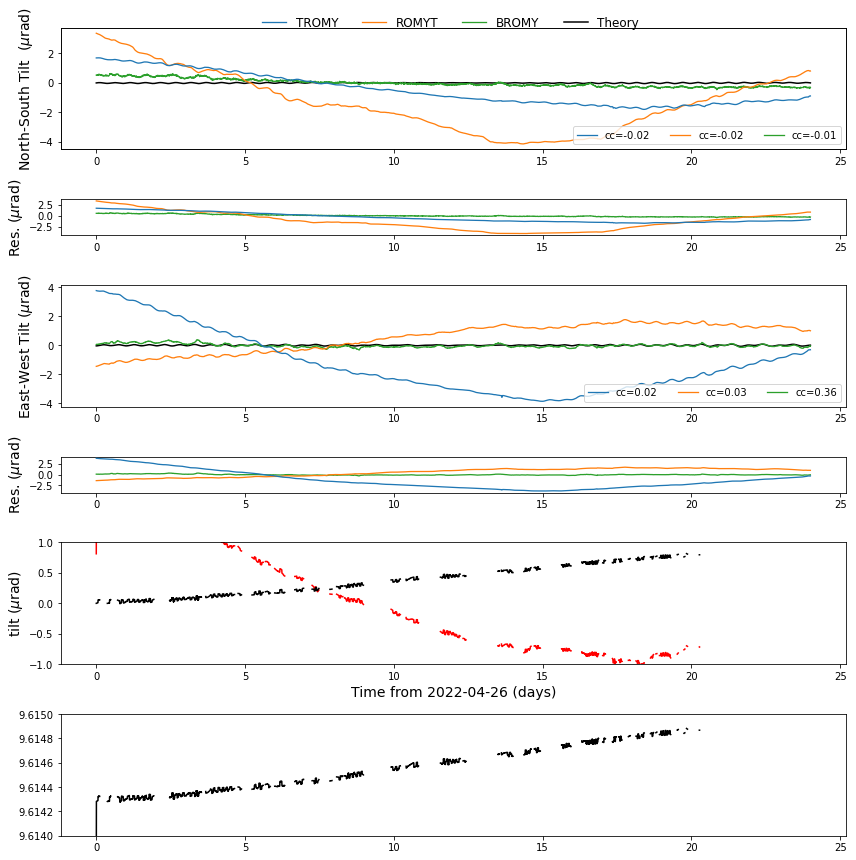

In [767]:
def __makeplot_residuals():
    
    from numpy import corrcoef, nan, correlate
    
    NN = 10
    
    fig = plt.figure(figsize=(12,12))
    ax1 = plt.subplot2grid((NN,1), (0,0), rowspan=2)
    ax2 = plt.subplot2grid((NN,1), (2,0), sharex=ax1)
    ax3 = plt.subplot2grid((NN,1), (3,0), rowspan=2, sharex=ax1)
    ax4 = plt.subplot2grid((NN,1), (5,0), sharex=ax1)
    ax5 = plt.subplot2grid((NN,1), (6,0), rowspan=2, sharex=ax1)
    ax6 = plt.subplot2grid((NN,1), (8,0), rowspan=2, sharex=ax1)

    fig.subplots_adjust(hspace=0.02)
    
    font = 14
    linew = 1.3
    scaling, unit = 1e6, r"$\mu$rad" ## micro strain
    scaling_time = 86400

    t1 = UTCDateTime("2022-04-26")
    t2 = UTCDateTime("2022-05-20")
    

    tromy_n_trace_lp = st_f2.select(station="TROMY", channel="MAN")[0].trim(t1, t2)
    tromy_e_trace_lp = st_f2.select(station="TROMY", channel="MAE")[0].trim(t1, t2)
    romyt_n_trace_lp = st_f2.select(station="ROMYT", channel="MAN")[0].trim(t1, t2)
    romyt_e_trace_lp = st_f2.select(station="ROMYT", channel="MAE")[0].trim(t1, t2)
    bromy_n_trace_lp = st_f2.select(station="DROMY", channel="LAN")[0].trim(t1, t2)
    bromy_e_trace_lp = st_f2.select(station="DROMY", channel="LAE")[0].trim(t1, t2)
    
    tilt_n_theo = tilt_theo.select(channel="*N")[0].trim(t1, t2)
    tilt_e_theo = tilt_theo.select(channel="*E")[0].trim(t1, t2)
    
    
    
    out_tromy_n_cc = corrcoef(tromy_n_trace_lp.data, tilt_n_theo.data)
    out_romyt_n_cc = corrcoef(romyt_n_trace_lp.data, tilt_n_theo.data)
    out_bromy_n_cc = corrcoef(bromy_n_trace_lp.data, tilt_n_theo.data)
    
    out_tromy_e_cc = corrcoef(tromy_e_trace_lp.data, tilt_e_theo.data)
    out_romyt_e_cc = corrcoef(romyt_e_trace_lp.data, tilt_e_theo.data)
    out_bromy_e_cc = corrcoef(bromy_e_trace_lp.data, tilt_e_theo.data)
    
    
    ## -------------------------------------
    
    ax1.plot(tromy_n_trace_lp.times()/scaling_time, tromy_n_trace_lp.data*scaling, label=f"TROMY", lw=linew, zorder=3)
    ax1.plot(romyt_n_trace_lp.times()/scaling_time, romyt_n_trace_lp.data*scaling, label=f"ROMYT", lw=linew, zorder=2)   
    ax1.plot(bromy_n_trace_lp.times()/scaling_time, bromy_n_trace_lp.data*scaling, label=f"BROMY", lw=linew, zorder=1)   

    ax1_1 = ax1.twinx()
    ax1_1.get_yaxis().set_visible(False)
    
    ax1_1.plot(tromy_n_trace_lp.times()/scaling_time, tromy_n_trace_lp.data*scaling*nan, label=f"cc={round(out_tromy_n_cc[0][1],2)}", lw=linew, zorder=3)
    ax1_1.plot(romyt_n_trace_lp.times()/scaling_time, romyt_n_trace_lp.data*scaling*nan, label=f"cc={round(out_romyt_n_cc[0][1],2)}", lw=linew, zorder=2)   
    ax1_1.plot(bromy_n_trace_lp.times()/scaling_time, bromy_n_trace_lp.data*scaling*nan, label=f"cc={round(out_bromy_n_cc[0][1],2)}", lw=linew, zorder=1)   
    
    
    ax2.plot(tromy_n_trace_lp.times()/scaling_time, (tromy_n_trace_lp.data-tilt_n_theo.data)*scaling, label=f"", lw=linew, zorder=3)
    ax2.plot(romyt_n_trace_lp.times()/scaling_time, (romyt_n_trace_lp.data-tilt_n_theo.data)*scaling, label=f"", lw=linew, zorder=2)   
    ax2.plot(bromy_n_trace_lp.times()/scaling_time, (bromy_n_trace_lp.data-tilt_n_theo.data)*scaling, label=f"", lw=linew, zorder=1)   

    ax3.plot(tromy_e_trace_lp.times()/scaling_time, tromy_e_trace_lp.data*scaling, label=f"cc={round(out_tromy_e_cc[0][1],2)}", lw=linew, zorder=3)
    ax3.plot(romyt_e_trace_lp.times()/scaling_time, romyt_e_trace_lp.data*scaling, label=f"cc={round(out_romyt_e_cc[0][1],2)}", lw=linew, zorder=2)
    ax3.plot(bromy_e_trace_lp.times()/scaling_time, bromy_e_trace_lp.data*scaling, label=f"cc={round(out_bromy_e_cc[0][1],2)}", lw=linew, zorder=1)

    ax4.plot(tromy_e_trace_lp.times()/scaling_time, (tromy_e_trace_lp.data-tilt_e_theo.data)*scaling, label=f"", lw=linew, zorder=3)
    ax4.plot(romyt_e_trace_lp.times()/scaling_time, (romyt_e_trace_lp.data-tilt_e_theo.data)*scaling, label=f"", lw=linew, zorder=2)   
    ax4.plot(bromy_e_trace_lp.times()/scaling_time, (bromy_e_trace_lp.data-tilt_e_theo.data)*scaling, label=f"", lw=linew, zorder=1)   

    
    ## Theo Tilt
    ax1.plot(tilt_theo.select(channel="*N")[0].times()/scaling_time, tilt_theo.select(channel="*N")[0].data*scaling, 'k', label="Theory", zorder=0)
    ax3.plot(tilt_theo.select(channel="*E")[0].times()/scaling_time, tilt_theo.select(channel="*E")[0].data*scaling, 'k', zorder=0)
    
    ## beat frequency
    smoothing = 5
    cut_off = int(smoothing/2)
    beat.trim(t1,t2)
#     ax5.scatter(beat.times()/scaling_time, beat.data, s=0.2)
#     ax5.plot(beat.times()[cut_off:-cut_off]/scaling_time, __smooth(beat.data, smoothing)[cut_off:-cut_off], "k", zorder=2)
    tilt = __to_tilt(beat.data)
    tilt -= tilt[0]
    tilt_cp = tilt * 1e6
    
    tilt_theo2 = tilt_n_theo.copy().resample(1/60).data[:-9]
    tilt_tromy_n_2 = st_f2.copy().select(station="TROMY", channel="MAN")[0].resample(1/60).data[:-9]
    
    tilt = tilt + (tilt_tromy_n_2 - tilt_theo2)
    
    tilt *= scaling
    ax5.plot(beat.times()/scaling_time, __smooth(tilt,5), "r", zorder=2)
    ax5.plot(beat.times()/scaling_time, __smooth(tilt_cp,5), "k", zorder=2)

    ax5.set_ylim(-1, 1)
#     ax5.set_ylim(553.37, 553.41)
    
    
    
    P = __to_H(beat.data)
    ax6.plot(beat.times()/scaling_time, __smooth(P,5), "k", zorder=2)
#     ax6.set_ylim(33.654, 33.657)
    ax6.set_ylim(9.614, 9.615)
    
    ax6.ticklabel_format(useOffset=False, style='plain')    

    ax1.set_ylabel(f"North-South Tilt  ({unit})", fontsize=font)
    ax2.set_ylabel(f"Res. ({unit})", fontsize=font)
    ax3.set_ylabel(f"East-West Tilt ({unit})", fontsize=font)
    ax4.set_ylabel(f"Res. ({unit})", fontsize=font)
#     ax5.set_ylabel(f"Beat note (Hz)",fontsize=font)
    ax5.set_ylabel(f"tilt ($\mu$rad)",fontsize=font)
    
#     ax1.legend(loc=1, fontsize=font-2, ncol=3, bbox_to_anchor=(0.85, 1.))
    ax1_1.legend(loc=4, fontsize=font-4, ncol=3)
    ax3.legend(loc=4, fontsize=font-4, ncol=3)
        
    
#     ax1.set_ylim(-.25, .25)
#     ax2.set_ylim(-.2, .2)
#     ax3.set_ylim(-.25, .25)
#     ax4.set_ylim(-.1, .1)

    dx1, dx2 = 0, 25
#     ax1.set_xlim(dx1, dx2)
#     ax2.set_xlim(dx1, dx2)
#     ax3.set_xlim(dx1, dx2)
#     ax4.set_xlim(dx1, dx2)
    
    ax5.set_xlabel(f"Time from {(tromy_n_trace_lp.stats.starttime + dx1*86400).date} (days)", fontsize=font)
    
    ax1.legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.75, 1.18), ncol=4, framealpha=0, facecolor="w")

    fig.tight_layout()
    return fig 

fig = __makeplot_residuals()

4.23198227729e-05  /°C


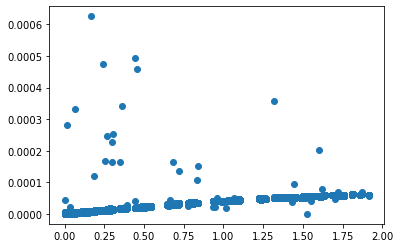

In [768]:
t1 = UTCDateTime("2022-04-26")
t2 = UTCDateTime("2022-05-20")

temp = TROMY.copy().select(channel="*T")[0].resample(1/60).trim(t1, t2).data
temp -= nanmean(temp[:20])

H = __to_H(beat.data)

H_expected = 2*53.93/11.3

H_rel = abs(H-H[0])/H_expected 

plt.scatter(temp, H_rel)

print(np.nanmedian(H_rel/temp), " /°C")

In [769]:
# __savefig(fig, outpath=config['output_figures'], outname="Tilt_ALL_EarthTides_TempCorrect_TheoResiduals_BeatNote", mode="png", dpi=None)

In [770]:
# import numpy as np
# w1 = np.arcsin(np.deg2rad(553.375 * 33.6 * 632.8e-9 / 4 / 53.93 / (2*np.pi/86400)))

# w2 = np.arcsin(np.deg2rad(553.41 * 33.6 * 632.8e-9 / 4 / 53.93 / (2*np.pi/86400)))

# abs(w1-w2)*1e6

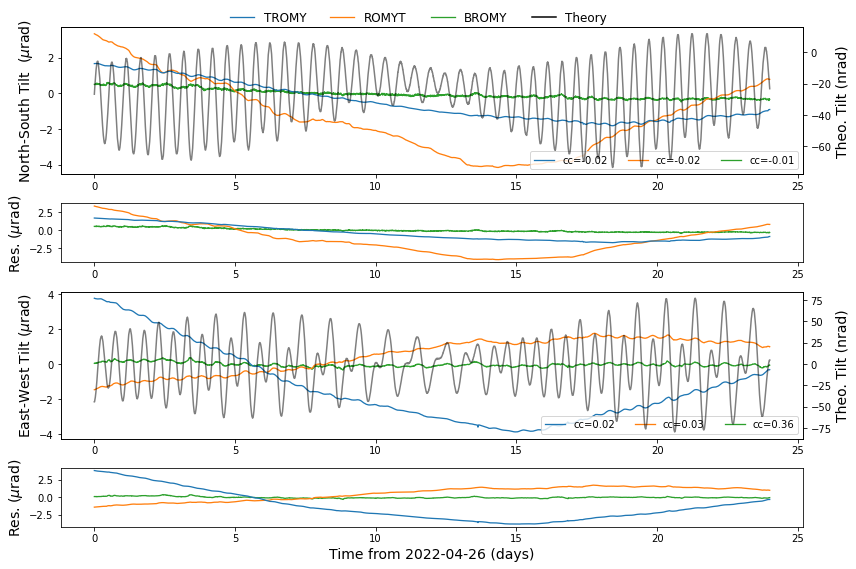

In [771]:
def __makeplot_residuals2():
    
    fig = plt.figure(figsize=(12,8))
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=2)
    ax2 = plt.subplot2grid((6,1), (2,0), sharex=ax1)
    ax3 = plt.subplot2grid((6,1), (3,0), rowspan=2, sharex=ax1)
    ax4 = plt.subplot2grid((6,1), (5,0), sharex=ax1)

    fig.subplots_adjust(hspace=0.05)
    
    font = 14
    linew = 1.3
    scaling, unit = 1e6, r"$\mu$rad" ## micro strain
    scaling_time = 86400

    t1 = UTCDateTime("2022-04-26")
    t2 = UTCDateTime("2022-05-20")
    

    tromy_n_trace_lp = st_f2.select(station="TROMY", channel="MAN")[0].trim(t1, t2)
    tromy_e_trace_lp = st_f2.select(station="TROMY", channel="MAE")[0].trim(t1, t2)
    romyt_n_trace_lp = st_f2.select(station="ROMYT", channel="MAN")[0].trim(t1, t2)
    romyt_e_trace_lp = st_f2.select(station="ROMYT", channel="MAE")[0].trim(t1, t2)
    bromy_n_trace_lp = st_f2.select(station="DROMY", channel="LAN")[0].trim(t1, t2)
    bromy_e_trace_lp = st_f2.select(station="DROMY", channel="LAE")[0].trim(t1, t2)
    
    tilt_n_theo = tilt_theo.select(channel="*N")[0].trim(t1, t2)
    tilt_e_theo = tilt_theo.select(channel="*E")[0].trim(t1, t2)
    
    
    from numpy import corrcoef, nan, correlate
    out_tromy_n_cc = corrcoef(tromy_n_trace_lp.data, tilt_n_theo.data)
    out_romyt_n_cc = corrcoef(romyt_n_trace_lp.data, tilt_n_theo.data)
    out_bromy_n_cc = corrcoef(bromy_n_trace_lp.data, tilt_n_theo.data)
    
    out_tromy_e_cc = corrcoef(tromy_e_trace_lp.data, tilt_e_theo.data)
    out_romyt_e_cc = corrcoef(romyt_e_trace_lp.data, tilt_e_theo.data)
    out_bromy_e_cc = corrcoef(bromy_e_trace_lp.data, tilt_e_theo.data)
    
    
    ## -------------------------------------
    
    ax1.plot(tromy_n_trace_lp.times()/scaling_time, tromy_n_trace_lp.data*scaling, label=f"TROMY", lw=linew, zorder=3)
    ax1.plot(romyt_n_trace_lp.times()/scaling_time, romyt_n_trace_lp.data*scaling, label=f"ROMYT", lw=linew, zorder=2)   
    ax1.plot(bromy_n_trace_lp.times()/scaling_time, bromy_n_trace_lp.data*scaling, label=f"BROMY", lw=linew, zorder=1)   

    ax1_0 = ax1.twinx()
    ax1_0.get_yaxis().set_visible(False)
    
    ax1_0.plot(tromy_n_trace_lp.times()/scaling_time, tromy_n_trace_lp.data*scaling*nan, label=f"cc={round(out_tromy_n_cc[0][1],2)}", lw=linew, zorder=3)
    ax1_0.plot(romyt_n_trace_lp.times()/scaling_time, romyt_n_trace_lp.data*scaling*nan, label=f"cc={round(out_romyt_n_cc[0][1],2)}", lw=linew, zorder=2)   
    ax1_0.plot(bromy_n_trace_lp.times()/scaling_time, bromy_n_trace_lp.data*scaling*nan, label=f"cc={round(out_bromy_n_cc[0][1],2)}", lw=linew, zorder=1)   
    
    ax2.plot(tromy_n_trace_lp.times()/scaling_time, (tromy_n_trace_lp.data-tilt_n_theo.data)*scaling, label=f"", lw=linew, zorder=3)
    ax2.plot(romyt_n_trace_lp.times()/scaling_time, (romyt_n_trace_lp.data-tilt_n_theo.data)*scaling, label=f"", lw=linew, zorder=2)   
    ax2.plot(bromy_n_trace_lp.times()/scaling_time, (bromy_n_trace_lp.data-tilt_n_theo.data)*scaling, label=f"", lw=linew, zorder=1)   

    ax3.plot(tromy_e_trace_lp.times()/scaling_time, tromy_e_trace_lp.data*scaling, label=f"cc={round(out_tromy_e_cc[0][1],2)}", lw=linew, zorder=3)
    ax3.plot(romyt_e_trace_lp.times()/scaling_time, romyt_e_trace_lp.data*scaling, label=f"cc={round(out_romyt_e_cc[0][1],2)}", lw=linew, zorder=2)
    ax3.plot(bromy_e_trace_lp.times()/scaling_time, bromy_e_trace_lp.data*scaling, label=f"cc={round(out_bromy_e_cc[0][1],2)}", lw=linew, zorder=1)

    ax4.plot(tromy_e_trace_lp.times()/scaling_time, (tromy_e_trace_lp.data-tilt_e_theo.data)*scaling, label=f"", lw=linew, zorder=3)
    ax4.plot(romyt_e_trace_lp.times()/scaling_time, (romyt_e_trace_lp.data-tilt_e_theo.data)*scaling, label=f"", lw=linew, zorder=2)   
    ax4.plot(bromy_e_trace_lp.times()/scaling_time, (bromy_e_trace_lp.data-tilt_e_theo.data)*scaling, label=f"", lw=linew, zorder=1)   

    ax1.plot(tilt_theo.select(channel="*N")[0].times()/scaling_time, tilt_theo.select(channel="*N")[0].data*nan, 'k', label="Theory", zorder=0, alpha=1)

    
    ax1_1 = ax1.twinx()
    ax1_1.plot(tilt_theo.select(channel="*N")[0].times()/scaling_time, tilt_theo.select(channel="*N")[0].data*scaling*1e3, 'k', zorder=0, alpha=0.5)
    ax1_1.set_ylabel("Theo. Tilt (nrad)", fontsize=font)
    
    ax3_1 = ax3.twinx()
    ax3_1.plot(tilt_theo.select(channel="*E")[0].times()/scaling_time, tilt_theo.select(channel="*E")[0].data*scaling*1e3, 'k', zorder=0, alpha=0.5)
    ax3_1.set_ylabel("Theo. Tilt (nrad)", fontsize=font)
    
    ax1.set_ylabel(f"North-South Tilt  ({unit})", fontsize=font)
    ax2.set_ylabel(f"Res. ({unit})", fontsize=font)
    ax3.set_ylabel(f"East-West Tilt ({unit})", fontsize=font)
    ax4.set_ylabel(f"Res. ({unit})", fontsize=font)

#     ax1.legend(loc=1, fontsize=font-2, ncol=3, bbox_to_anchor=(0.85, 1.))
    ax1_0.legend(loc=4, fontsize=font-4, ncol=3)
    ax3.legend(loc=4, fontsize=font-4, ncol=3)
        
    
#     ax1.set_ylim(-.25, .25)
#     ax2.set_ylim(-.2, .2)
#     ax3.set_ylim(-.25, .25)
#     ax4.set_ylim(-.1, .1)

    dx1, dx2 = 0, 25
#     ax1.set_xlim(dx1, dx2)
#     ax2.set_xlim(dx1, dx2)
#     ax3.set_xlim(dx1, dx2)
#     ax4.set_xlim(dx1, dx2)
    
    ax4.set_xlabel(f"Time from {(tromy_n_trace_lp.stats.starttime + dx1*86400).date} (days)", fontsize=font)
    
    ax1.legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.75, 1.18), ncol=4, framealpha=0, facecolor="w")

    fig.tight_layout()
    return fig

fig = __makeplot_residuals2()

In [772]:
# __savefig(fig, outpath=config['output_figures'], outname="Tilt_ALL_EarthTides_TempCorrect_TheoResiduals2", mode="png", dpi=None)

## Compare with Ambient Air Pressure

In [324]:
from numpy import nan
BROMY 
# BROMY = BROMY.split().merge(fill_value=nan)
BROMY = BROMY.split().merge(fill_value="interpolate")
BROMY

3 Trace(s) in Stream:
BW.DROMY..LAE | 2022-04-24T00:10:00.000000Z - 2022-06-11T23:50:00.000000Z | 600.0 s, 7055 samples
BW.DROMY..LAN | 2022-04-24T00:10:00.000000Z - 2022-06-11T23:50:00.000000Z | 600.0 s, 7055 samples
BW.DROMY..LAT | 2022-04-24T00:10:00.000000Z - 2022-06-11T23:50:00.000000Z | 600.0 s, 7055 samples

In [325]:
def __load_wromy_data(channel, config):
    
    from os import listdir
    from tqdm.notebook import tqdm
    from pandas import read_pickle, concat

    files = listdir(config['pathToWromy']+channel)
    
    for n, file in enumerate(tqdm(files)):
        df0 = read_pickle(config['pathToWromy']+channel+"/"+file)
        if n == 0:
            df_raw = df0
        else: 
            df_raw = concat([df_raw,df0])
    df_raw.reset_index()
    return df_raw

In [326]:
def __add_wromy_trace(stream, ws):

    df0 = __load_wromy_data(ws, config)
    df0.dropna(inplace=True)
    df0.sort_values('TimeStamp', inplace=True)
    df0.reset_index(drop=True, inplace=True)
    wsx = df0

    ## limit to tbeg - tend
    times_absolut = stream.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))
    wsx = wsx[(wsx['totalSeconds'] >= times_absolut[0]) & (wsx['totalSeconds'] <= times_absolut[-1]+500)]

    if len(wsx['totalSeconds']) != stream[0].stats.npts:
        print(f"-> npts don't match: {len(wsx['totalSeconds'])} != {stream[0].stats.npts}")
    
    ## create trace and addto stream
    tr_wsx = stream.select(channel="*T")[0].copy()
    tr_wsx.data = array(wsx['Pressure (hPa)'])
    tr_wsx.stats.channel = ws
    stream += tr_wsx

In [327]:
__add_wromy_trace(ROMYT, "WS9")
__add_wromy_trace(TROMY, "WS5")
__add_wromy_trace(BROMY, "WS1")

In [421]:
st_all2 = Stream()

st_all2 += ROMYT.copy().select(channel="*N").split()
st_all2 += ROMYT.copy().select(channel="*E").split()
st_all2 += ROMYT.copy().select(channel="WS*").split()

st_all2 += TROMY.copy().select(channel="*N").split()
st_all2 += TROMY.copy().select(channel="*E").split()
st_all2 += TROMY.copy().select(channel="*WS*").split()

st_all2 += BROMY.copy().select(channel="*N").split()
st_all2 += BROMY.copy().select(channel="*E").split()
st_all2 += BROMY.copy().select(channel="*WS*").split()

st_all2.merge(method=1, fill_value='interpolate')


st_all2_pp = st_all2.copy()

st_all2_pp.detrend('demean')
st_all2_pp.taper(0.1);


st_f = st_all2_pp.copy()

# fmin, fmax = 1/(10*86400), 1/(0.1*86400)
# filter_str = f"bp: {fmin:.2e} - {fmax:.2e} Hz"
# st_f.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

st_f.filter("highpass", freq=1e-5, corners=4, zerophase=True);

st_f.detrend("demean")

9 Trace(s) in Stream:
BW.DROMY..LAE | 2022-04-24T00:10:00.000000Z - 2022-06-11T23:50:00.000000Z | 600.0 s, 7055 samples
BW.DROMY..LAN | 2022-04-24T00:10:00.000000Z - 2022-06-11T23:50:00.000000Z | 600.0 s, 7055 samples
BW.DROMY..WS1 | 2022-04-24T00:10:00.000000Z - 2022-06-11T23:50:00.000000Z | 600.0 s, 7055 samples
BW.ROMYT..MAE | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples
BW.ROMYT..MAN | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples
BW.ROMYT..WS9 | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..WS5 | 2022-04-24T00:00:00.039999Z - 2022-06-11T23:50:00.039999Z | 600.0 s, 7056 samples

In [444]:
t1 = UTCDateTime("2022-04-30")
t2 = UTCDateTime("2022-05-30")


tilt_theo = __load_theoretical_tilt()

## double amplitudes for better match.. not yet understood!
for tr in tilt_theo:
    tr.data *= 2

tromy_n_trace_lp = st_f.copy().select(station="TROMY", channel="MAN")[0].trim(t1, t2)
tromy_e_trace_lp = st_f.copy().select(station="TROMY", channel="MAE")[0].trim(t1, t2)
romyt_n_trace_lp = st_f.copy().select(station="ROMYT", channel="MAN")[0].trim(t1, t2)
romyt_e_trace_lp = st_f.copy().select(station="ROMYT", channel="MAE")[0].trim(t1, t2)
bromy_n_trace_lp = st_f.copy().select(station="DROMY", channel="LAN")[0].trim(t1, t2)
bromy_e_trace_lp = st_f.copy().select(station="DROMY", channel="LAE")[0].trim(t1, t2)

tromy_w = st_f.copy().select(channel="WS5")[0].trim(t1,t2)
romyt_w = st_f.copy().select(channel="WS9")[0].trim(t1,t2)
bromy_w = st_f.copy().select(channel="WS1")[0].trim(t1,t2)

tilt_n_theo = tilt_theo.copy().select(channel="*N")[0].trim(t1, t2)
tilt_e_theo = tilt_theo.copy().select(channel="*E")[0].trim(t1, t2)

factor = 1

tromy_n_res = tromy_n_trace_lp.data - tilt_n_theo.data*factor
romyt_n_res = romyt_n_trace_lp.data - tilt_n_theo.data*factor
bromy_n_res = bromy_n_trace_lp.data - tilt_n_theo.data*factor

tromy_e_res = tromy_e_trace_lp.data - tilt_e_theo.data*factor
romyt_e_res = romyt_e_trace_lp.data - tilt_e_theo.data*factor
bromy_e_res = bromy_e_trace_lp.data - tilt_e_theo.data*factor


In [445]:
def __estimate_linear_trend(x_arr, y_arr, derive=None, smooth=None, relative=None, set_odr=None):
    
    '''
    
    >>> output = __estimate_linear_trend(x, y, derive=None, smooth=None, relative=None, odr=None)
  
    INPUT: 
        - x_array:       array: data for x-axis as numpy array
        - y_array:       array: data for y-axis as numpy array 
        - derive:        bool: (if x is derived or not) 
        - smooth:        integer: degree of smoothing 
        - relative:      bool: relative to x[0]
        - odr:           bool: select orthogonal distance regression (ODR) instead of linear regression

        
    OUTPUT:
        - output:        dictionary with output values and information
        
    '''
    
    from scipy import odr
    from scipy.stats import linregress
    from numpy import gradient, power
    
    ## prepare output dictionary
    output = {}
    
    if derive:
        x_arr = gradient(x_arr, 2)
        
    if smooth:
        x_arr = __smooth(x_arr, smooth)

    if relative:
        x_arr -= x_arr[1]
        
    ## compute linear regression of data
    out = linregress(x_arr, y_arr)    
    
    ## extract to output
    output['slope'] = out.slope
    output['intercept'] = out.intercept  
    

    
    ## use an orthogonal distance regression (odr) for trend estimate
    if set_odr is not None:
        
        def f(B, x):
            '''Linear function y = m*x + b'''
            return B[0]*x + B[1]   
        
        s_x, s_y = 1, 1
        print(f" -> std x and y set to: {s_x} and {s_y}")

        beta_x, beta_y = 1e-8, 1e-8
        print(f" -> beta x and y set to: {beta_x} and {beta_y}")

        linear = odr.Model(f)
        mydata = odr.Data(x_arr, y_arr, wd=1./power(s_x,2), we=1./power(s_y,2))
        myodr = odr.ODR(mydata, linear, beta0=[beta_x, beta_y])
        myoutput = myodr.run()
    
        ## extract to output        
        output['slope'] = myoutput.beta[0]
        output['intercept'] = myoutput.beta[1]
    
    
    return output

In [450]:
def __makeplot_tilt_pressure(n_trace_lp, n_res, e_trace_lp, e_res, w):

    from numpy import roll

    def __add_colorbar(mappable):
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        from matplotlib import colors, ticker

        last_axes = plt.gca()
        ax = mappable.axes
        fig = ax.figure
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(mappable, cax=cax)
        cbar.set_label("Time (days)", fontsize=font-1, labelpad=-40, color="white")
        cbar.ax.xaxis.set_major_formatter(ticker.ScalarFormatter())        
        plt.sca(last_axes)
        return cbar



    time_scaling, time_unit = 86400, "days"
    tilt_scaling, tilt_unit = 1e6, r"$\mu$rad"

    font = 14
    
    
    ## comput linear trends
    trend_n = __estimate_linear_trend(w.data, n_res, derive=None, smooth=None, relative=None, set_odr=None)
    trend_e = __estimate_linear_trend(w.data, e_res, derive=None, smooth=None, relative=None, set_odr=None)
    
    trend_n_slope = f"{round(trend_n.get('slope')*1e9, 1)} nrad/hPa"
    trend_e_slope = f"{round(trend_e.get('slope')*1e9, 1)} nrad/hPa"
    
    ## ----------------

    fig, ax = plt.subplots(4,1, figsize=(15,10))

    plt.subplots_adjust(hspace=0.4)

    
    ## ----

    ax[0].plot(n_trace_lp.times()/time_scaling, n_res*tilt_scaling, zorder=2)
    ax[0].plot(n_trace_lp.times()/time_scaling, n_trace_lp.data*tilt_scaling, color="grey", zorder=1, alpha=0.5)

    shift = 0

    ## make second axis for pressure
    ax1_1 = ax[0].twinx()
    ax1_1.plot(w.times()/time_scaling, roll(w.data,shift), "k")
    
    ## scatter plot pressure vs. tilt
    cb1 = ax[1].scatter(roll(w.data,shift), n_res*tilt_scaling, s=2, c=w.times()/time_scaling)
  
    ## plot regression
    regression_n = (trend_n.get('intercept')+ trend_n.get('slope')*w.data)*tilt_scaling
#     ax[1].plot(w.data, regression_n, color='k', ls=':', label=trend_n_slope)
    
    corrected_n = (n_res-trend_n.get('slope')*w.data)*tilt_scaling
    ax[0].plot(n_trace_lp.times()/time_scaling, corrected_n, color="r", zorder=3, alpha=0.5)   


    ## ----
    
    ax[2].plot(e_trace_lp.times()/time_scaling, e_res*tilt_scaling, zorder=2)
    ax[2].plot(e_trace_lp.times()/time_scaling, e_trace_lp.data*tilt_scaling, color="grey", zorder=1, alpha=0.5)

    ## make second axis for pressure
    ax2_1 = ax[2].twinx()
    ax2_1.plot(w.times()/time_scaling, roll(w.data, shift), "k")

    ## scatter plot pressure vs. tilt
    cb2 = ax[3].scatter(roll(w.data,shift), e_res*tilt_scaling, s=2, c=w.times()/time_scaling)
    
    ## plot regression    
    regression_e = (trend_e.get('intercept')+ trend_e.get('slope')*w.data)*tilt_scaling
#     ax[3].plot(w.data, regression_e, color='k', ls=':', label=trend_e_slope)
    
    corrected_e = (e_res-trend_e.get('slope')*w.data)*tilt_scaling
    ax[2].plot(e_trace_lp.times()/time_scaling, corrected_e, color="r", zorder=3, alpha=0.5)
    
    
    ## ----
    
    cbar1 = __add_colorbar(cb1)
    cbar2 = __add_colorbar(cb2)

    ax[1].legend(loc=2)
    ax[3].legend(loc=2)
    
    ax[0].set_ylabel(f"Tilt N-S ({tilt_unit})", fontsize=font)
    ax1_1.set_ylabel(f"Pressure (hPa)", fontsize=font)
    ax[0].set_xlabel(f"Time ({time_unit})", fontsize=font, labelpad=-0)
    ax[1].set_ylabel(f"Tilt N-S ({tilt_unit})", fontsize=font)
    ax[2].set_ylabel(f"Tilt E-W ({tilt_unit})", fontsize=font)
    ax[1].set_xlabel(f"Pressure (hPa)", fontsize=font, labelpad=-0)
    ax2_1.set_ylabel(f"Pressure (hPa)", fontsize=font)
    ax[2].set_xlabel(f"Time ({time_unit})", fontsize=font, labelpad=-0)
    ax[3].set_ylabel(f"Tilt E-W ({tilt_unit})", fontsize=font)
    ax[3].set_xlabel(f"Pressure (hPa)", fontsize=font, labelpad=-0)

    plt.show();
    return fig

No handles with labels found to put in legend.
No handles with labels found to put in legend.


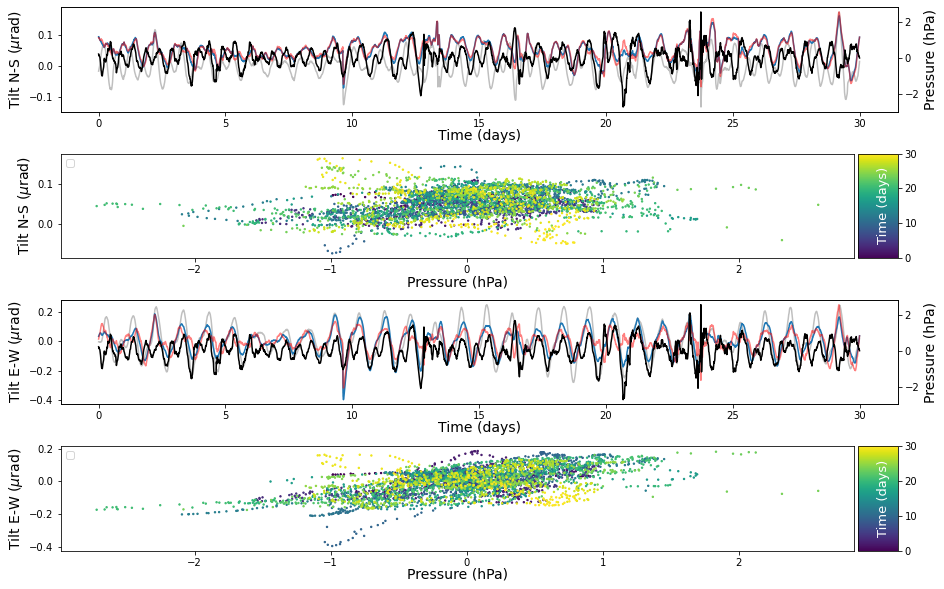

In [451]:
fig = __makeplot_tilt_pressure(tromy_n_trace_lp, tromy_n_res, tromy_e_trace_lp, tromy_e_res, tromy_w);
# __savefig(fig, outpath=config['output_figures'], outname="Tilt_TROMY_EarthTides_TempCorrect_Pressure", mode="png", dpi=None)

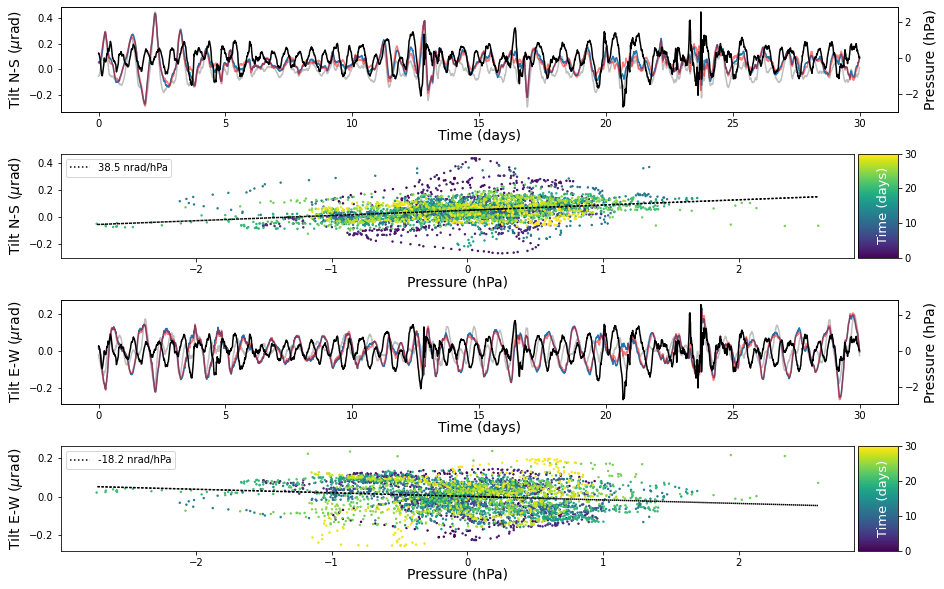

In [448]:
fig = __makeplot_tilt_pressure(romyt_n_trace_lp, romyt_n_res, romyt_e_trace_lp, romyt_e_res, romyt_w);
# __savefig(fig, outpath=config['output_figures'], outname="Tilt_ROMYT_EarthTides_TempCorrect_Pressure", mode="png", dpi=None);

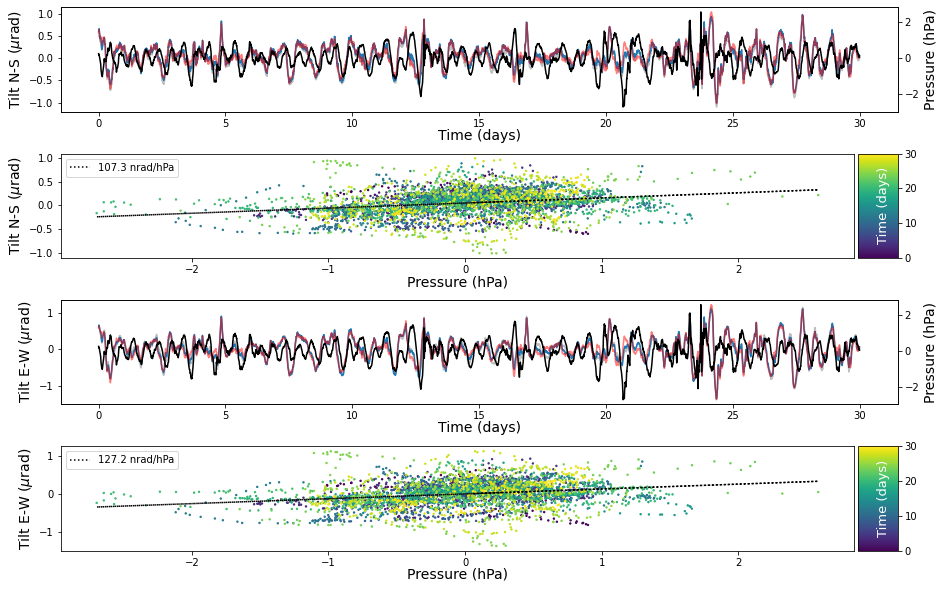

In [449]:
fig = __makeplot_tilt_pressure(bromy_n_trace_lp, bromy_n_res, bromy_e_trace_lp, bromy_e_res, bromy_w);
# __savefig(fig, outpath=config['output_figures'], outname="Tilt_BROMY_EarthTides_TempCorrect_Pressure", mode="png", dpi=None);

In [428]:
# from andbro__crosscorrelation import __crosscorrelation

# y1 = (tromy_w.data)/max(tromy_w.data)
# y2 = tromy_n_res/max(tromy_n_res)

# # __crosscorrelation(y1, y2, deltaT=600)

In [ ]:
def __makeplotStreamPSD(config, st, st2=None):

    from scipy import fftpack
    from numpy import log10, median
    from scipy.signal import welch, periodogram, hann

    
    nblock =  1028
    overlap = None
    win = hann(nblock, True)

    NN = len(st)
    
    fig, axes = plt.subplots(NN,2,figsize=(15,15), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['station','channel'], reverse=True)
    
    for i, tr in enumerate(st):

#         ff, Pxx = welch(tr.data, 
#                         fs=tr.stats.sampling_rate, 
#                         window=win, 
#                         noverlap=overlap, 
#                         nfft=nblock,
#                         scaling="density",
#                         return_onesided=True,
#                        )
        ff, Pxx = periodogram(tr.data, 
                              fs=tr.stats.sampling_rate, 
                              window=None,
                              scaling="density",
                              return_onesided=True,
                             )
        
        if st2 is not None:
            ff2, Pxx2 = welch(st2[i].data, 
                              fs=st2[i].stats.sampling_rate, 
                              window=win,
                              noverlap=overlap, 
                              nfft=nblock,
                              scaling="density", 
                              return_onesided=True,
                             )
        
        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()/86400,
                    tr.data*1e6,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
#         axes[i,1].loglog(ff, Pxx, color='black', lw=1.0,)
        axes[i,1].semilogx(ff, Pxx, color='black', lw=1.0,)
        
        if st2 is not None:
#             axes[i,1].loglog(ff2, Pxx2, color='red', lw=1.0,)       
            axes[i,1].semilogx(ff2, Pxx2, color='red', lw=1.0,)       
        
        
        axes[i,1].vlines(1/86400,min(Pxx[:]), max(Pxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(2/86400,min(Pxx[:]), max(Pxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        
        axes[NN-1,0].set_xlabel("Time (days)")
        axes[NN-1,1].set_xlabel("Frequency (Hz)")
        
        axes[i,1].set_ylim(min(Pxx[:]), max(Pxx[:]))
        
        axes[i,0].set_ylabel(r'$\Omega$ ($\mu$rad)')    
        axes[i,1].set_ylabel(r'PSD (rad$^2$/Hz)')        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#         axes[i,1].set_xlim(3e-6,1e-4)
        axes[i,1].set_xlim(1e-5,5e-5)
        
        axes[0,1].set_ylim(0, 2e6)
        axes[3,1].set_ylim(0, 2e6)
        axes[6,1].set_ylim(0, 2e6)
        
        axes[1,1].set_ylim(0, 5e-9)
        axes[2,1].set_ylim(0, 5e-8)
        axes[4,1].set_ylim(0, 3e-8)
        axes[5,1].set_ylim(0, 1e-8)
        axes[7,1].set_ylim(0, 9e-8)
        axes[8,1].set_ylim(0, 9e-8)
        
    return fig

In [ ]:
fig = __makeplotStreamPSD(config, st_f, st2=None);

## Compare with PSD

Check if earth tides are visible

In [ ]:
def __makeplotStreamPSD(config, st, st2=None):

    from scipy import fftpack
    from numpy import log10, median
    from scipy.signal import welch, periodogram, hann


    nblock =  4096
    overlap = None
    win = hann(nblock, True)

    NN = len(st)
    
    fig, axes = plt.subplots(NN,2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st):

        ff, Pxx = welch(tr.data, 
                        fs=tr.stats.sampling_rate, 
                        window=win, 
                        noverlap=overlap, 
                        nfft=nblock,
                        scaling="density",
                        return_onesided=True,
                       )
#         ff, Pxx = periodogram(tr.data, 
#                               fs=tr.stats.sampling_rate, 
#                               window=win,
#                               scaling="density",
#                               return_onesided=True,
#                              )
        
        if st2 is not None:
            ff2, Pxx2 = welch(st2[i].data, 
                              fs=st2[i].stats.sampling_rate, 
                              window=win,
                              noverlap=overlap, 
                              nfft=nblock,
                              scaling="density", 
                              return_onesided=True,
                             )
        
        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()/86400,
                    tr.data*1e6,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].loglog(ff, Pxx, color='black', lw=1.0,)
        
        if st2 is not None:
            axes[i,1].loglog(ff2, Pxx2, color='red', lw=1.0,)       
        
        
        axes[i,1].vlines(1/86400,min(Pxx[:]), max(Pxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(2/86400,min(Pxx[:]), max(Pxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        
        axes[NN-1,0].set_xlabel("Time (days)")
        axes[NN-1,1].set_xlabel("Frequency (Hz)")
        
        axes[i,1].set_ylim(min(Pxx[:]), max(Pxx[:]))
        
        axes[i,0].set_ylabel(r'$\Omega$ ($\mu$rad)')    
        axes[i,1].set_ylabel(r'PSD (rad$^2$/Hz)')        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        axes[i,1].set_xlim(1e-6,1e-3)

    return fig

In [ ]:
fig = __makeplotStreamPSD(config, st_all, st2=None);

In [ ]:
# __savefig(fig, outpath=config['output_figures'], outname="Tilt_ALL_EarthTides_PSD", mode="png", dpi=None)

In [ ]:
def __makeplotStreamSpectra(st, config):

    from scipy import fftpack
    from numpy import abs

    NN = len(st)

    fig, axes = plt.subplots(NN,2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st):

        comp_fft = abs(fftpack.fft(tr.data))
        ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
        comp_fft = fftpack.fftshift(comp_fft)


        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()/86400,
                    tr.data*1e6,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        fxx = abs(fftpack.fft(tr.data)[1:len(ff)//2])
        axes[i,1].loglog(
                    ff[1:len(ff)//2],
                    fxx,
                    color='black',
                    lw=1.0,
                    )
        
        axes[i,1].vlines(1/86400,min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(2/86400,min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        
        axes[NN-1,0].set_xlabel("Time (days)")
        axes[NN-1,1].set_xlabel("Frequency (Hz)")
                      
        axes[i,0].set_ylabel(r'$\Omega$ ($\mu$rad)')    
        axes[i,1].set_ylabel(r'ASD (rad/Hz)')        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].set_xlim(1e-7,0.25)
#         axes[i,1].set_ylim(1e-12,1e-9)

    return fig

In [ ]:
fig = __makeplotStreamSpectra(st_all, config);